In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


import scipy.sparse as sp
import scipy.sparse.linalg as spla

from scipy.stats import linregress as linreg

import scipy.fftpack as fft


from scipy.io import loadmat
from pytex import *

#from scipy.linalg import toeplitz, circulant
#import sympy as smp

In [2]:
matplotlib.rcParams.update({'font.size': 14})

# 1

In [12]:
table = loadmat('hw04_matlab/timings.mat')['table']
table = np.array(table).T
latex_table(table, ['$k$', '$m^2$', 'GE', 'SOR', 'Sparse GE', 'DST', 'Multigrid'])

	\begin{center}
		\begin{tabular}{|c|c|c|c|c|c|c|}
			\hline
			$k$&$m^2$&GE&SOR&Sparse GE&DST&Multigrid\\ \hline
			3&49&0.0006967&0.0008175&0.0004143&0.0003157&0.0019262\\ \hline
			4&225&0.0037434&0.0023273&0.0007004&0.0003316&0.0030616\\ \hline
			5&961&0.018593&0.0078251&0.0015111&0.0004459&0.0052118\\ \hline
			6&3969&0.57195&0.052586&0.0056945&0.0009885&0.009997\\ \hline
			7&16129&41.263&0.44997&0.027005&0.0020163&0.026672\\ \hline
			8&65025&2808.4&4.2597&0.12434&0.0061616&0.078019\\ \hline
			9&2.6112e+05&1.8377e+05&38.512&0.67354&0.0324&0.41839\\ \hline
			10&1.0465e+06&1.1862e+07&531.5&3.0856&0.13551&2.385\\ \hline
		\end{tabular}
	\end{center}


In [10]:
print(10**6/(60*60*24))

11.574074074074074


# 3

In [3]:
def foo(x,y):
    return -8*np.pi**2*np.cos(2*np.pi*x)*np.cos(2*np.pi*y)

def exact(x,y):
    return np.cos(2*np.pi*x)*np.cos(2*np.pi*y)

In [23]:
def fd2poissondct()
m = 99 #2**6-1
a, b = 0, 1

h = (b-a)/(m+1)
xs = np.linspace(a, b, m+2)
X, Y = np.meshgrid(xs, xs)
fs = foo(X, Y)
# fhat=(S*f)*S^(-1)
f_hat = fft.idct(fft.dct(fs, type=1, axis=0)/2,type=1, axis=1)/(m+1)
#f_hat = fft.dct(fft.dct(fs, type=1, axis=0)/2,type=1, axis=1)/2
cos_vec = np.cos(np.pi*np.arange(0,m+2)/(m+1))
denom = 2*(np.add.outer(cos_vec, cos_vec)-2)
denom[0,0] = 1 #temporary to allow for the division
u_hat = h**2 * f_hat / denom
u_hat[0,0] = 0
us = fft.dct(fft.idct(u_hat, type=1, axis=0)/(m+1),type=1, axis=1)/2
#us = fft.idct(fft.idct(u_hat, type=1, axis=0)/(m+1),type=1, axis=1)/(m+1)


u_true = exact(X,Y)

error = la.norm(us - u_true)/ la.norm(u_true)
print(error)

0.0003290517629364549


In [24]:
print(denom[2,2])
print(1/(-8*np.pi**2))
print(-8*np.pi**2)

-0.007893086286913764
-0.012665147955292222
-78.95683520871486


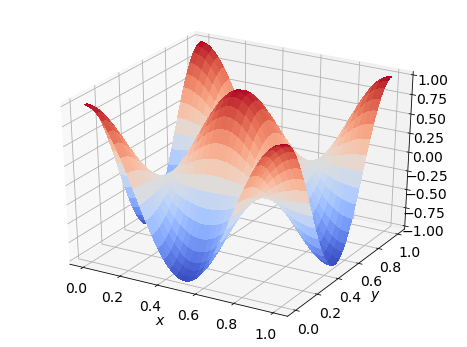

In [25]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X,Y, us, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
#fig.colorbar(surf)
plt.show()

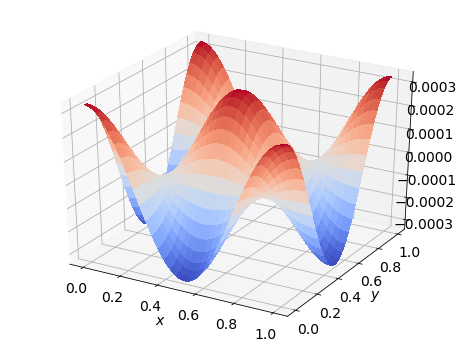

In [26]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X,Y, us-u_true, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
#fig.colorbar(surf)
plt.show()

# 4

In [3]:
def fd2_poisson_compact(forcing, boundary, a, b, m):
    bndry = np.linspace(a,b,m+2, endpoint=True)
    X,Y = np.meshgrid(bndry, bndry)
    h = (b-a)/(m+1)
    us = np.zeros((m+2,m+2))
    us[0]    = boundary(a*np.ones(m+2), bndry)
    us[-1]   = boundary(b*np.ones(m+2), bndry)
    us[:,0]  = boundary(bndry, a*np.ones(m+2))
    us[:,-1] = boundary(bndry, b*np.ones(m+2))
    
    

In [22]:
def forcing(x,y):
    temp = 2*np.pi*(x+2*y)
    return 10*np.pi**2 * np.exp(np.sin(temp)) * (-2*np.sin(temp) + np.cos(2*temp)+1)
                                
def boundary(x,y):
    return np.exp(np.sin(2*np.pi*(x+2*y)))

<IPython.core.display.Javascript object>


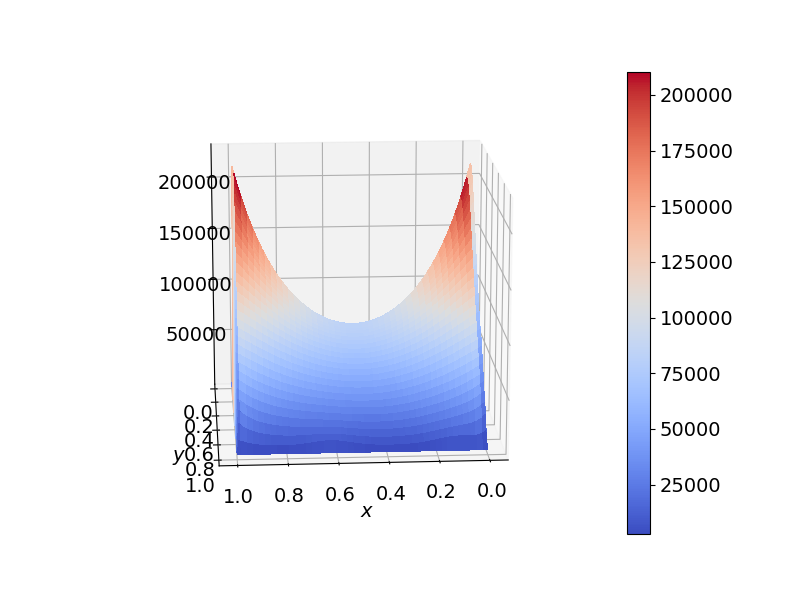

In [96]:
k = 7
a, b = 0, 1

m = 2**k-1
h = (b-a)/(m+1)
bndry = np.linspace(a,b,m+2, endpoint=True)
X,Y = np.meshgrid(bndry, bndry)

us = np.zeros((m+2,m+2))
us[0]    = boundary(a*np.ones(m+2), bndry)
us[-1]   = boundary(b*np.ones(m+2), bndry)
us[:,0]  = boundary(bndry, a*np.ones(m+2))
us[:,-1] = boundary(bndry, b*np.ones(m+2))

fs = forcing(X,Y)

rhs  = 8.0*fs[1:-1,1:-1]
rhs +=     fs[0:-2,1:-1]
rhs +=     fs[2:,  1:-1]
rhs +=     fs[1:-1,0:-2]
rhs +=     fs[1:-1,2:  ]
rhs /= 12.0

lhs_bndry = np.zeros((m,m))
lhs_bndry +=   us[0:-2, 0:-2]
lhs_bndry +=   us[0:-2, 2:  ]
lhs_bndry +=   us[2:  , 0:-2]
lhs_bndry +=   us[2:  , 2:  ]
lhs_bndry += 4*us[1:-1, 0:-2]
lhs_bndry += 4*us[1:-1, 2:  ]
lhs_bndry += 4*us[0:-2, 1:-1]
lhs_bndry += 4*us[2:  , 1:-1]
lhs_bndry *= 1/(6*h**2)

rhs -= lhs_bndry

rhs = rhs.reshape(m**2)

diagonals = [1, 4, 1, 4, -20, 4, 1, 4, 1]
diagonals = [[d]*m**2 for d in diagonals]
offsets = [-m-1, -m, -m+1, -1, 0, 1, m-1, m, m+1]
D = sp.diags(diagonals, offsets, shape=(m**2,m**2), format='csr')

us[1:-1, 1:-1] = spla.spsolve(D, rhs).reshape((m,m))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X,Y, us, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
fig.colorbar(surf)
plt.show()


In [91]:
rhs.shape

(49,)

In [65]:
print(sp.diags([[-1]*6, [0]*6, [1]*6], [-1, 0, 1], shape=(5,5)).todense())

[[ 0.  1.  0.  0.  0.]
 [-1.  0.  1.  0.  0.]
 [ 0. -1.  0.  1.  0.]
 [ 0.  0. -1.  0.  1.]
 [ 0.  0.  0. -1.  0.]]
